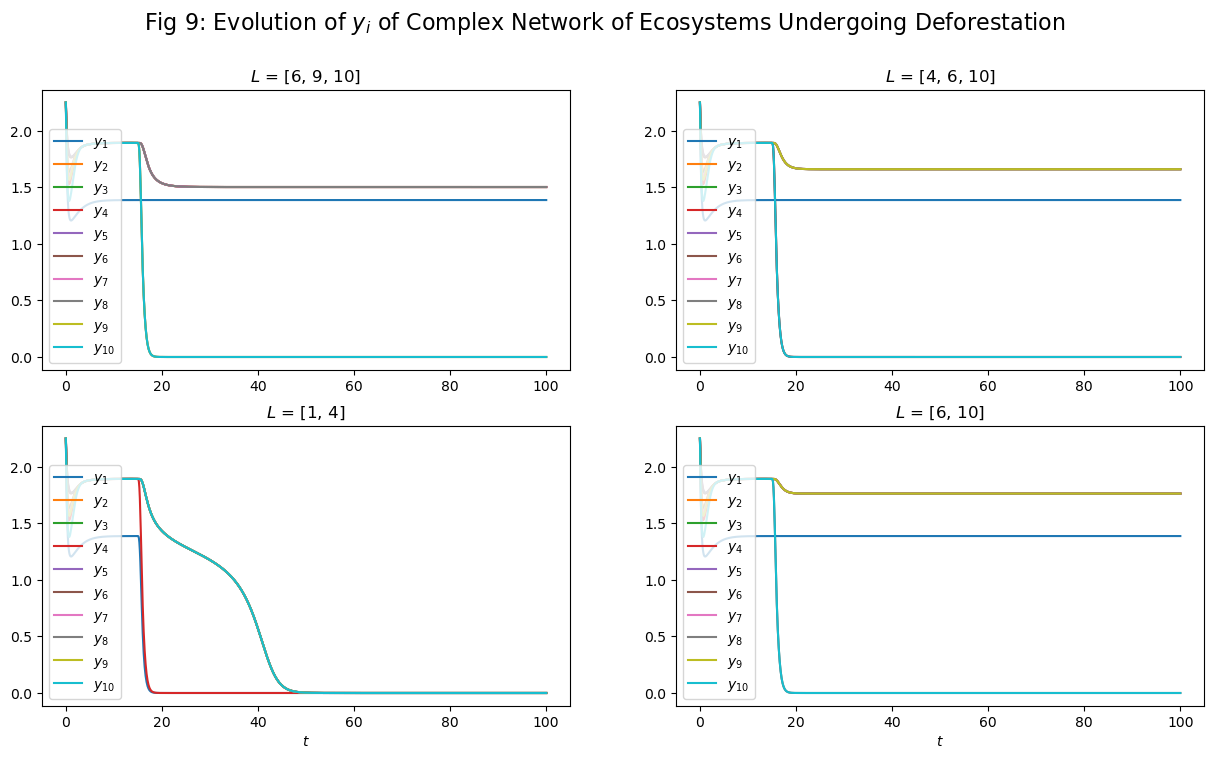

PyObject Text(0.5, 0.98, 'Fig 9: Evolution of $y_i$ of Complex Network of Ecosystems Undergoing Deforestation')

In [4]:
# Attempt to reproduces figure 9 by deforesting
# the selected ecosystems at timestep = 15
# ... see docs in last cell
# to inspect `ecosystems_times_to_deforest`
using Distributions
using Random
using PyPlot
using DrWatson
using Suppressor
using LaTeXStrings
#@quickactivate :CSSim
include(joinpath(srcdir(), "n_forest.jl"))

# Forests `L` to deforest (from figure 9)
ecosystems_to_deforest_mat = [
    [6, 9, 10],
    [4, 6, 10],
    [1, 4],
    [6, 10],
]

# Generate parameters
n = 10
T = 100
params_container = [
    Dict{Symbol,Any}(
        :ρ  => 4.2, 
        :f  => 1.0,
        :α₀ => -1.0, 
        :w₀ =>  1.0,
        :a₁ => 1.0, 
        :h  => 2.0, 
        :a₂ => 0.0, 
        :d  => repeat([900 / (n-1)], n-1), 
        :l  => 600.0, 
        :P₀ => 1.05, 
        :β₁ => 0.0, 
        :β₂ => 0.15,
        :n  => n,
        # without changing the seed with the `i` arg,
        # times at which deforestation occurs will be same
        :ecosystems_to_deforest => ecosystems_times_to_deforest(
            T, 
            ecosystems_to_deforest,
            # killing the forest early leads to more deforestation
            # over the T period of system evolution
            repeat([15], length(ecosystems_to_deforest)), 
            #[],
            n, 
            #i
        ),
    )
    for ecosystems_to_deforest in ecosystems_to_deforest_mat
];

# Evolution of yᵢ given perturbations
nrows = 2
ncols = 2
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 8))
    
y_density = 2.25
x_ix = 1
y_ix = 2
n_states = 2
@suppress begin
    for i in 1:nrows
        for j in 1:ncols
            flat_ix = (i-1)*ncols + j
            params = params_container[flat_ix]

            # Generate initial conditions 
            u0 = fill(y_density, params[:n], 2)
            u0[:, x_ix] .= 4*rand(MersenneTwister(30), params[:n])

            # Compute trajectories
            n_forest_ds = n_forest_system(u0, params)
            S, t = trajectory(n_forest_ds, T)
            S_tensor = reshape(Matrix(S), :, params[:n], n_states)

            # iterate through ecosystems and plot trajectories
            for k in 1:params[:n]
                y_k = S_tensor[:, k, y_ix]
                axs[i, j].plot(t, y_k, label=LaTeXString("\$y_{$(k)}\$"))
            end 

            axs[i, j].legend(loc="lower left")
            i == nrows ? axs[i, j].set_xlabel(L"$t$") : nothing
            axs[i, j].set_title(LaTeXString("\$L\$ = $(getproperty.(params[:ecosystems_to_deforest], :i))"))
        end 
    end 
end 

fig.suptitle(
    L"Fig 9: Evolution of $y_i$ of Complex Network of Ecosystems Undergoing Deforestation", 
    fontsize=16)

In [2]:
?ecosystems_times_to_deforest

search: ecosystems_times_to_deforest



```
ecosystems_times_to_deforest(
    T::Int, N::Int, n::Int, seed = 42)::Vector{EcosystemDeforestTime}
```

Return vector of elements `(i, tstar)` to randomly deforest ecosystem `i` at  time `tstar`.

# Arguments

  * `T::Int`: Total time system system is evolved (e.g., T = 50 for 50 years)
  * `N::Int`: Number of ecosystems to deforest.
  * `n::Int`: Total number of ecosystems in the complex network.
  * `seed=42`: Random seed for sampling.

[1] : Expression (15) from Cantin2020

---

```
ecosystems_times_to_deforest(
    T::Int, 
    deforest_ecosystems::Union{Vector{Int}, Vector{Any}}, 
    deforest_times::Union{Vector{Int}, Vector{Any}}, 
    n::Int, 
    seed = 42)::Vector{EcosystemDeforestTime}
```

Return vector of `(i, tstar)` with selected ecosystems/times to deforest.

# Arguments

  * `T::Int`: Total time system system is evolved (e.g., T = 50 for 50 years)
  * `deforest_ecosystems::Union{Vector{Int}, Vector{Any}}`: Vector of ecosystem    ids to deforest. Pass an empty vector `[]` if you want random ecosystem ids    to be used.
  * `deforest_times::Union{Vector{Int}, Vector{Any}}`: Vector of times to        deforest. Pass an empty vector `[]` if you want random times to be used.
  * `n`: Total number of ecosystems in the complex network.
  * `seed=42`: Random seed for sampling.
